All dependencies are installed and imported. 

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.metrics import classification_report
seed = 54198
tf.random.set_seed(seed)
np.random.seed(seed)


The path is set to data. it is very important that the data folder should be placed in same file as this jupyter notebook.

In [2]:
myPath = pathlib.Path('data/words')
words = np.array(tf.io.gfile.listdir(str(myPath)))
words = words[words != 'index']
word_names = tf.io.gfile.glob(str(myPath)+ '/*/*')
word_names = tf.random.shuffle(word_names)
numWords = len(word_names)
print('Total number of Spoken words:', numWords)
print('Total number of Samples per Folder:',len(tf.io.gfile.listdir(str(myPath/words[0]))))
print('words:', words, 'Word count:', len(words))

Total number of Spoken words: 4350
Total number of Samples per Folder: 290
words: ['come' 'eight' 'five' 'four' 'Go' 'left' 'nine' 'No' 'one' 'right'
 'seven' 'six' 'three' 'two' 'Zero'] Word count: 15


In [3]:
Training_set = word_names[:int(numWords*0.8)]
validation_set = word_names[int(numWords*0.8): int(numWords*0.8) + int(numWords*0.1)]
test_set = word_names[-int(numWords*0.1):]

print('Training set size', len(Training_set))
print('Validation set size', len(validation_set))
print('Test set size', len(test_set))


Training set size 3480
Validation set size 435
Test set size 435


The tensorshape of a sample audio file is displayed. Also Filenames are along with matching audio waveforms.

In [4]:
test_file = tf.io.read_file('data/words/seven/F02_B2_D7_M3.wav')
t_words, _ = tf.audio.decode_wav(contents=test_file)
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1) 
    return tf.squeeze(audio, axis=-1)
def filesNames(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]
def get_waveform_and_label(file_path):
  label = filesNames(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(Training_set)
waveform_ds = files_ds.map(map_func =get_waveform_and_label, num_parallel_calls=AUTOTUNE)
t_words.shape

TensorShape([60457, 1])

waveforms for 16 audio files choosen at random are displayed with labels. 

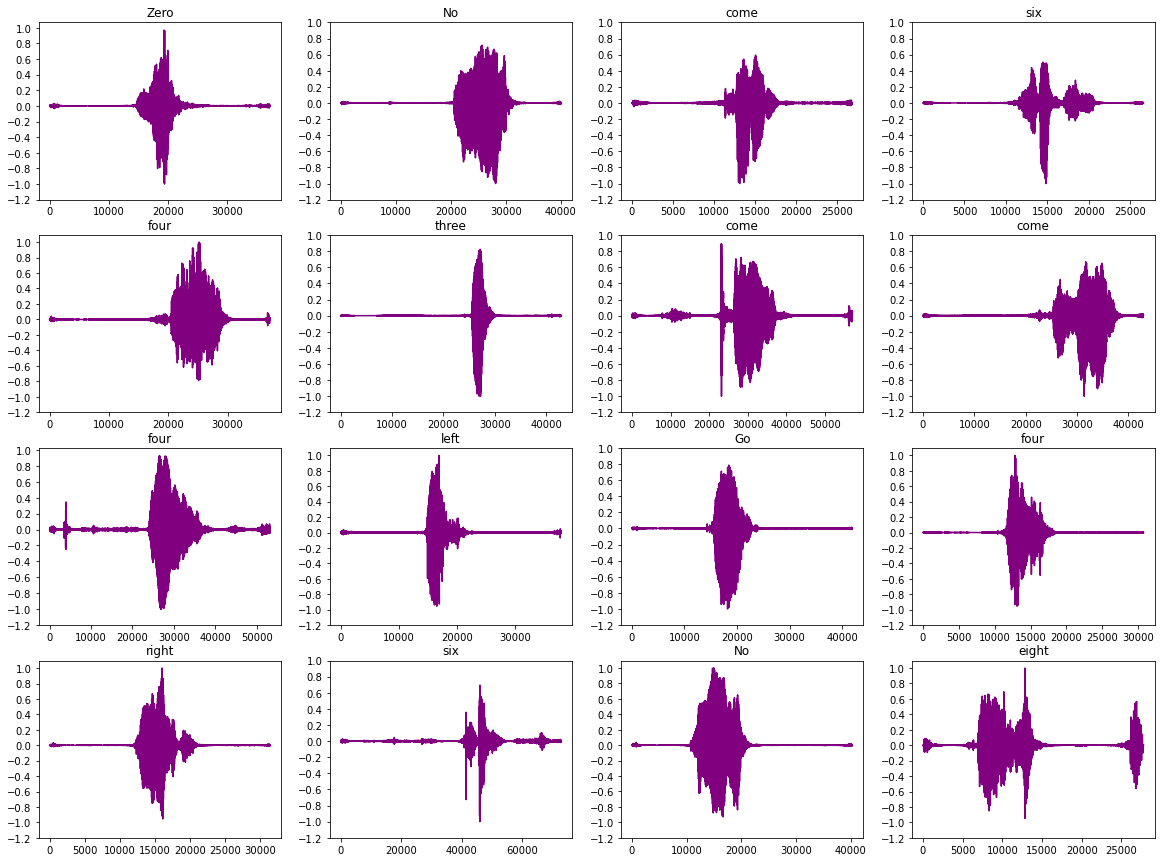

In [5]:
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, (audio, label) in enumerate(waveform_ds.take(16)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy(), color = 'purple')
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()



not all audio files are of the same length so a 10 second  zero padding is applied to all audio files that are less than ten seconds. the waveforms are also converted to spectograms. 

In [6]:
def get_spectrogram(waveform):
    waveform = waveform[:160000]
    zero_padding = tf.zeros([160000] - tf.shape(waveform),dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=564, frame_step=288)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('WORD:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

print('Audio playback')
display.display(display.Audio(waveform, rate=16000))



WORD: Zero
Waveform shape: (37298,)
Spectrogram shape: (554, 513, 1)
Audio playback


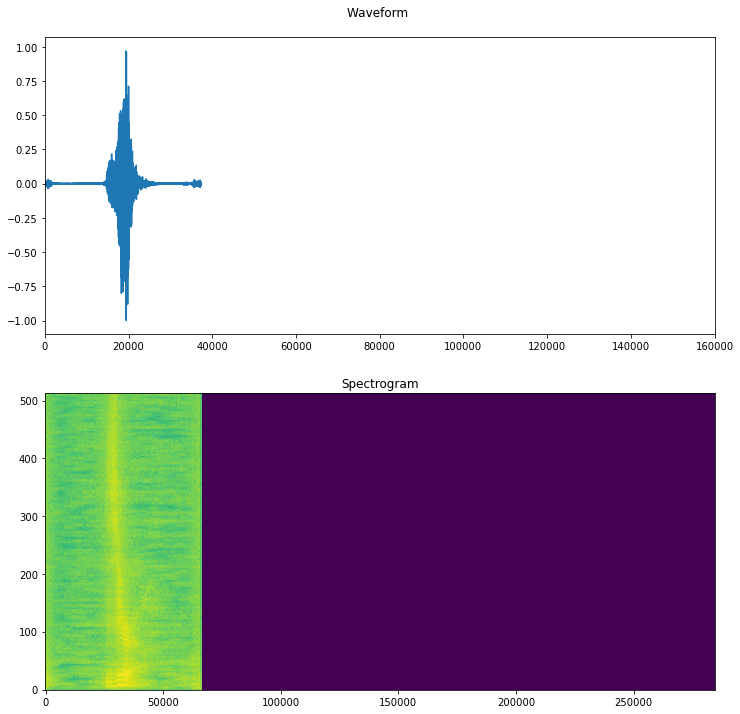

In [7]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='auto')
fig, axes = plt.subplots(2, figsize=(12, 12))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform \n')
axes[0].set_xlim([0, 160000])

plot_spectrogram(spectrogram.numpy(), axes[1])

axes[1].set_title('Spectrogram')
plt.show()



The method below acquires each audio file spectograma and label. instances where the word had to be  padded can be seen in the spectograms below.

tf.Tensor([37298], shape=(1,), dtype=int32)


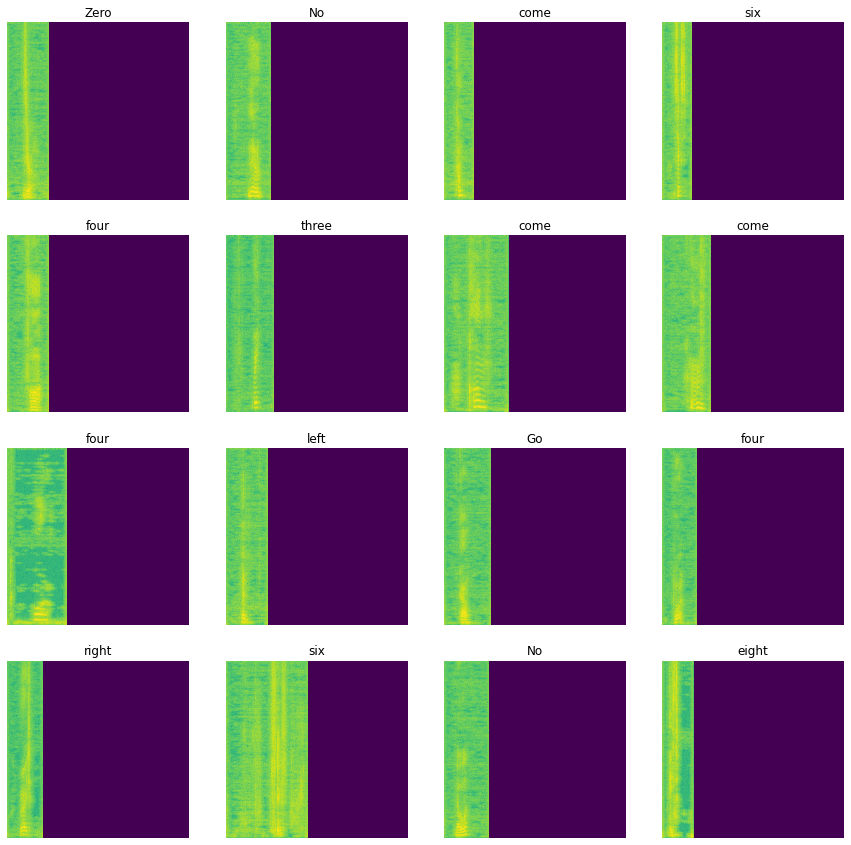

In [8]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == words)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)
print(tf.shape(waveform))
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(words[label_id.numpy()])
  ax.axis('off')

plt.show()




Dataset.cache and Dataset.prefetch operations are used to reduce processing time and the  data is set in batches for 32 for the training and validation of the model. 

The spectogram images gotten from the audio files is used by creating a convolutional neural network.  tf.keras.layers.Resizing and tf.keras.layers.Normalization are used to downsize  and normalize the model respectively

 

In [9]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
test_ds = preprocess_dataset(test_set)
val_ds = preprocess_dataset(validation_set)
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(words)

norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()




Input shape: (554, 513, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Model is Compiled and trained in batches of 32

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)



Epoch 1/10
109/109 [==============================] - 43s 381ms/step - loss: 2.5078 - accuracy: 0.1796 - val_loss: 2.2789 - val_accuracy: 0.3149
Epoch 2/10
109/109 [==============================] - 9s 83ms/step - loss: 2.1326 - accuracy: 0.3152 - val_loss: 1.9578 - val_accuracy: 0.3954
Epoch 3/10
109/109 [==============================] - 9s 81ms/step - loss: 1.8207 - accuracy: 0.4011 - val_loss: 1.7144 - val_accuracy: 0.5011
Epoch 4/10
109/109 [==============================] - 9s 80ms/step - loss: 1.6298 - accuracy: 0.4629 - val_loss: 1.5394 - val_accuracy: 0.5471
Epoch 5/10
109/109 [==============================] - 9s 80ms/step - loss: 1.4270 - accuracy: 0.5261 - val_loss: 1.4055 - val_accuracy: 0.6000
Epoch 6/10
109/109 [==============================] - 9s 81ms/step - loss: 1.2732 - accuracy: 0.5833 - val_loss: 1.2100 - val_accuracy: 0.6598
Epoch 7/10
109/109 [==============================] - 9s 81ms/step - loss: 1.1516 - accuracy: 0.6276 - val_loss: 1.1174 - val_accuracy: 0.68

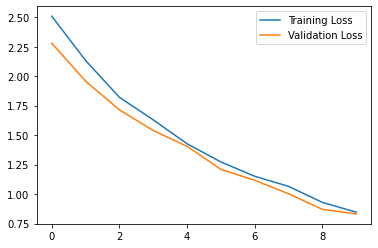

In [11]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


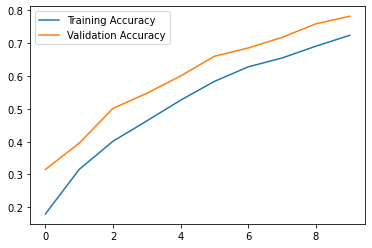

In [12]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

The model is tested and the accuracy at which it predicts samples in the test set is printed. 

In [13]:

t_words = []
t_labels = []

for audio, label in test_ds:
  t_words.append(audio.numpy())
  t_labels.append(label.numpy())

t_words = np.array(t_words)
t_labels = np.array(t_labels)

y_pred = np.argmax(model.predict(t_words), axis=1)
y_true = t_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'This model has performed with an accuracy rate of: {test_acc:.0%}')

This model has performed with an accuracy rate of: 83%


A confusion matrix and classification report are displayed to see how the model perfromed.

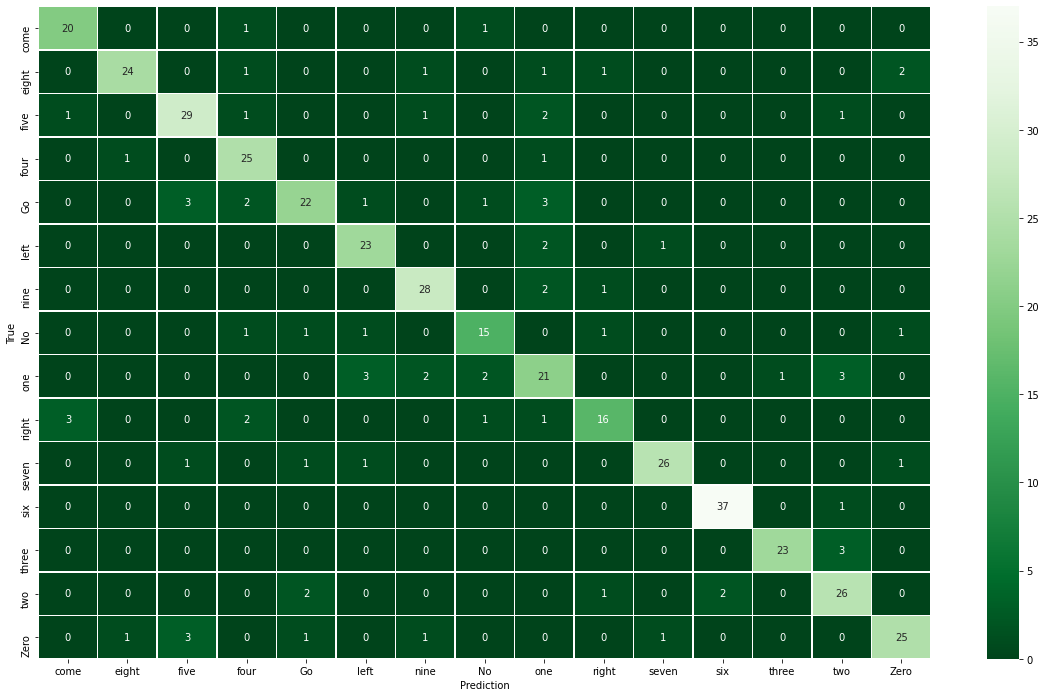

In [14]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(20, 12))

sns.heatmap(confusion_mtx, xticklabels=words, yticklabels=words, cmap='Greens_r',
            annot=True, fmt='g', linewidths=.5)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()


In [15]:
print(classification_report(y_true, y_pred, labels=np.unique(y_pred),  target_names= words))
#print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

        come       0.83      0.91      0.87        22
       eight       0.92      0.80      0.86        30
        five       0.81      0.83      0.82        35
        four       0.76      0.93      0.83        27
          Go       0.81      0.69      0.75        32
        left       0.79      0.88      0.84        26
        nine       0.85      0.90      0.88        31
          No       0.75      0.75      0.75        20
         one       0.64      0.66      0.65        32
       right       0.80      0.70      0.74        23
       seven       0.93      0.87      0.90        30
         six       0.95      0.97      0.96        38
       three       0.96      0.88      0.92        26
         two       0.76      0.84      0.80        31
        Zero       0.86      0.78      0.82        32

    accuracy                           0.83       435
   macro avg       0.83      0.83      0.82       435
weighted avg       0.83   

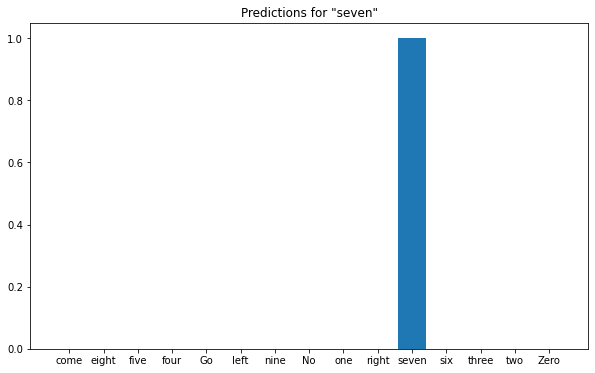

In [16]:
sample_file = myPath/'seven/F02_B2_D7_M8.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(50):
  prediction = model(spectrogram)
  plt.figure(figsize=(10,6))
  plt.bar(words, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{words[label[0]]}"')
  plt.show()


This done following tensorflow tutorial @https://www.tensorflow.org/tutorials/audio/simple_audio